In [43]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of data points
NUM_SAMPLES = 1000

# Kinetic parameters
MU_MAX = 0.870       # 1/h
K_S    = 0.215       # g/l
Y_XS   = 0.496       # g/g
Y_PX   = 0.2         # g/g
S_F    = 1.43 * 200  # g/l

# Initial conditions
X_0 = 5.85
S_0 = 0.013
V_0 = 1.56

# ODE solver parameters
ODE_SOLVER = 'LSODA'

# Time parameters
T_START = 0
T_END = 5
TIME_RANGE = int(T_END - T_START) # Absolute time 

# System dynamics
def system_dynamics(t, y, F) -> np.array:
    X, S, V = y
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

def plot_solution(sol: solve_ivp) -> None:
    plt.figure(figsize=(12,4))
    plt.plot(sol.t, sol.y[0], label='Biomass')
    plt.plot(sol.t, sol.y[1], label='Substrate')
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/l)')
    plt.legend()
    plt.show()
    

In [44]:
# MPC parameters
dt = 0.1                            # Time step
L = int(TIME_RANGE / dt)            # Number of steps
N_p = 7                             # Prediction horizon
Q = 1.5                             # Weight for tracking
Q_term = 0.0                        # Weight for terminal state
R = 0.1                             # Weight for control effort
OPTIMIZATION_METHOD = 'COBYLA' # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 0.1                  # l/h
DELTA_F_MAX = 0.05           # Maximum change in feed rate
F_0 = (F_MAX - F_MIN) / 2    # Initial feed rate
BOUNDS = [(F_MIN, F_MAX) for _ in range(N_p)] 

# X_setpoint
X_sp = 30

print(f'Number of steps: {L} and dt: {dt}')

Number of steps: 50 and dt: 0.1


In [45]:
# Load torch model
model_name = "pinn_model.pth"
model_exists = os.path.exists(f'./models/{model_name}')

def numpy_to_tensor(array):
    return torch.tensor(array, requires_grad=True, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.input = nn.Linear(input_dim, 128)
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 128)
        self.output = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.output(x)
        return x

if model_exists:
    net = PINN(input_dim=5, output_dim=3).to(DEVICE)
    net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
    net.eval()
else:
    raise FileNotFoundError(f"Model file './models/{model_name}' does not exist.")

In [ ]:
def optimize_feed_pytorch(X_init, S_init, V_init, T_s, F_prev=None):
    # Initialize F_opt as a torch parameter with requires_grad
    if F_prev is None:
        F_opt = torch.nn.Parameter(torch.full((N_p, 1), F_0, device=DEVICE))
    else:
        F_init = np.roll(F_prev, -1)
        F_init[-1] = F_init[-2]  # hold last value
        F_opt = torch.nn.Parameter(torch.from_numpy(F_init).float().to(DEVICE).reshape(-1, 1))

    optimizer = torch.optim.LBFGS([F_opt], lr=0.01, max_iter=50, tolerance_grad=1e-6, tolerance_change=1e-8)

    def closure():
        optimizer.zero_grad()
        X_ts = torch.tensor([[X_init]], dtype=torch.float32, device=DEVICE)
        S_ts = torch.tensor([[S_init]], dtype=torch.float32, device=DEVICE)
        V_ts = torch.tensor([[V_init]], dtype=torch.float32, device=DEVICE)

        J = torch.tensor(0.0, dtype=torch.float32, device=DEVICE)
        for k in range(N_p):
            t_input = torch.tensor([[T_s]], dtype=torch.float32, device=DEVICE)
            input_vec = torch.cat([t_input, X_ts, S_ts, V_ts, F_opt[k].unsqueeze(0)], dim=1)
            y_k = net(input_vec)
            X_next, S_next, V_next = y_k[0, 0], y_k[0, 1], y_k[0, 2]

            J += (Q * (X_next - X_sp) ** 2).squeeze()
            if k > 0:
                J += (R * (F_opt[k] - F_opt[k - 1]) ** 2).squeeze()

            X_ts = X_next.unsqueeze(0).unsqueeze(0)
            S_ts = S_next.unsqueeze(0).unsqueeze(0)
            V_ts = V_next.unsqueeze(0).unsqueeze(0)

        J.backward()
        return J

    optimizer.step(closure)

    # Clamp to bounds after optimization
    with torch.no_grad():
        F_opt.clamp_(F_MIN, F_MAX)

    return F_opt.detach().cpu().numpy().flatten()


In [47]:
X = np.zeros(L)
S = np.zeros(L)
V = np.zeros(L)
F = np.zeros(L)
X[0], S[0], V[0] = X_0, S_0, V_0

F_prev = np.full(N_p, F_0)

for i in tqdm(range(L-1)):
    F_opt = optimize_feed_pytorch(X[i], S[i], V[i], dt, F_prev)
    F_new = F_opt[0]
    F[i+1] = F_new
    F_prev = F_opt  # warm start for next iteration

    sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[X[i], S[i], V[i]], method=ODE_SOLVER, t_eval=[dt], args=(F_new,))
    X[i+1] = sol.y[0][-1]
    S[i+1] = sol.y[1][-1]
    V[i+1] = sol.y[2][-1]

100%|██████████| 49/49 [00:00<00:00, 187.63it/s]


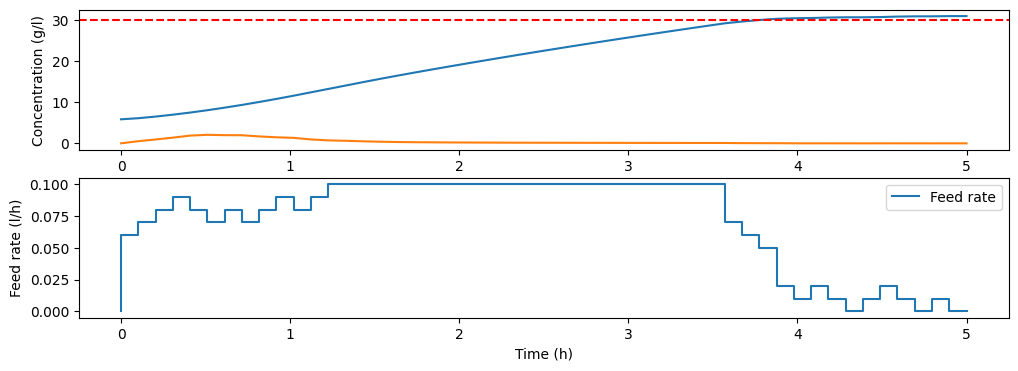

In [68]:
time= np.linspace(T_START, T_END, L)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(time, X, label='Biomass')
plt.plot(time, S, label='Substrate')
plt.axhline(y=X_sp, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')

plt.subplot(2,1,2)
plt.step(time, F, label='Feed rate')
plt.xlabel('Time (h)')
plt.ylabel('Feed rate (l/h)')
plt.legend()
plt.show()

Evaluate using real system dynamics

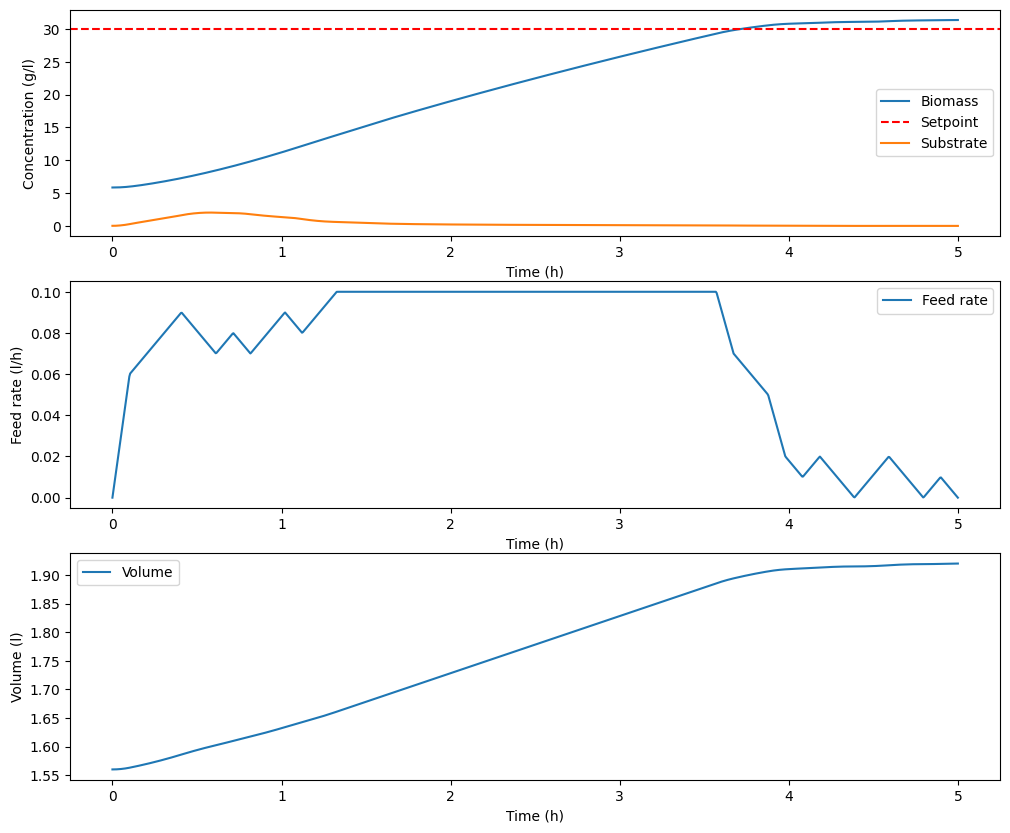

In [66]:
from scipy.interpolate import interp1d

# System dynamics
def simulate(t, y, F_func) -> np.array:
    
    F = F_func(t)   
    
    X, S, V = y
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt,dV_dt])

F_func = interp1d(time, F, kind='linear', fill_value='extrapolate')
t_eval = np.linspace(T_START, T_END, NUM_SAMPLES)
sol = solve_ivp(simulate, t_span=[T_START, T_END], y0=[X_0, S_0, V_0], method=ODE_SOLVER, t_eval=t_eval, args=(F_func,))

# Plot results
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.plot(sol.t, sol.y[0], label='Biomass')
plt.axhline(y=X_sp, color='r', linestyle='--', label='Setpoint')
plt.plot(sol.t, sol.y[1], label='Substrate')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(sol.t, F_func(sol.t), label='Feed rate')
plt.xlabel('Time (h)')
plt.ylabel('Feed rate (l/h)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(sol.t, sol.y[2], label='Volume')
plt.xlabel('Time (h)')
plt.ylabel('Volume (l)')
plt.legend()
plt.show()